# **Feature subset selection with the SFS algorithm**

In this notebook we will look at **Sequantial Forward Selection (SFS)**.

Do our imports.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

Mount Google Drive so that we can load our dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data.

It is a dataset about predicting fuel consumption of a car (liters per 100 km) when we know 14 features:

0. id – unique id of a car.
1. cylinders – the number of engine cylinders.
2. displacement – engine size.
3. horsepower – engine power.
4. weight_lbs – car weight in pounds.
5. weight_kg – car weight in kilograms.
6. acceleration – car acceleration.
7. year – car manufacturing year (from 1970 to 1982).
8. color – car color (encoded as integer from 0 to 4).
9. – 13. – additional information.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ML/auto-lpkm.tsv', sep='\t', header=0)
data

,id,cylinders,displacement,horsepower,weight_lbs,weight_kg,acceleration,model_year,color,more_info_1,more_info_2,more_info_3,more_info_4,more_info_5,l100km
0,0,4,98.0,79,2255,1023,17.7,76,1,94,91,49,97,68,9.0
1,1,4,113.0,95,2278,1033,15.5,72,4,97,58,66,85,38,9.8
2,2,8,351.0,153,4129,1873,13.0,72,1,41,8,15,83,70,16.8
3,3,4,97.0,88,2279,1034,19.0,73,2,53,3,42,2,82,11.8
4,4,6,199.0,97,2774,1258,15.5,70,0,74,53,24,51,53,13.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,4,91.0,67,1995,905,16.2,82,4,48,61,22,29,3,6.2
196,196,4,140.0,90,2408,1092,19.5,72,3,81,43,46,100,13,11.8
197,197,4,135.0,84,2370,1075,13.0,82,2,32,57,13,52,6,6.5
198,198,4,91.0,68,2025,918,18.2,82,4,55,88,70,53,54,6.4


The last column is the $y$, i.e., liters per 100 km which we must learn to predict.

In [ ]:
X = data.to_numpy()[:, 0:-1]
y = data.to_numpy()[:, -1]
data = data.drop('l100km', axis=1)

Take note of column names.

In [ ]:
feature_names = data.columns.values
feature_names

array(['id', 'cylinders', 'displacement', 'horsepower', 'weight_lbs',
       'weight_kg', 'acceleration', 'model_year', 'color', 'more_info_1',
       'more_info_2', 'more_info_3', 'more_info_4', 'more_info_5'],
      dtype=object)

Now let's loook at scatter plots of $x_i$ vs. $y$. Maybe we will see some correlations.

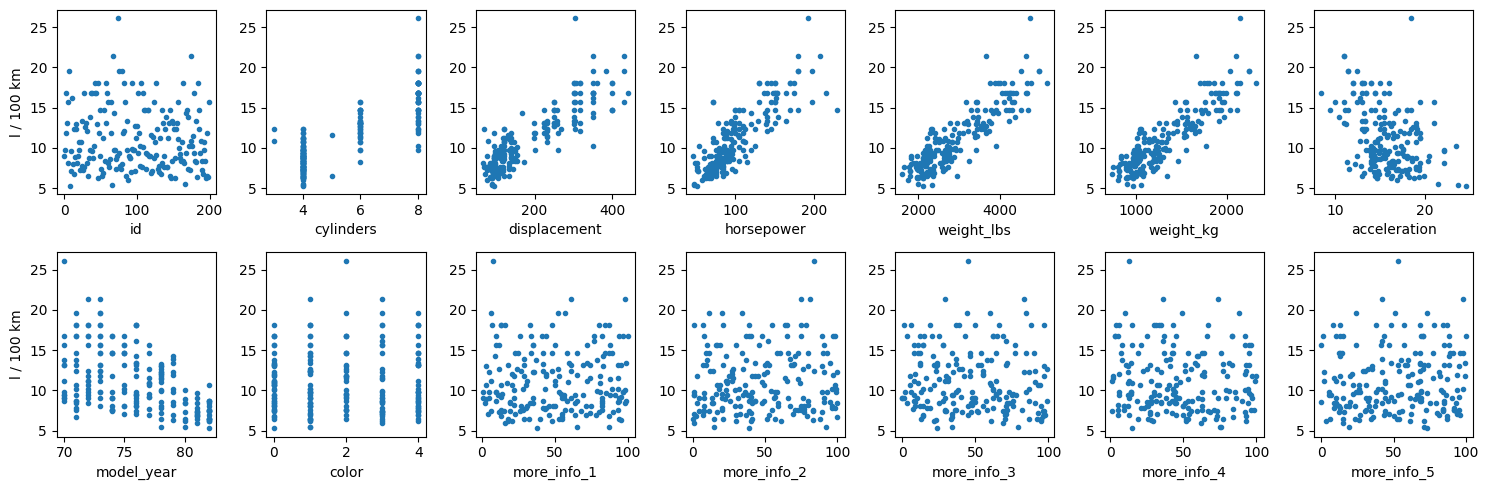

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(15, 5))
for r in range(0, 2):
    for c in range(0, 7):
      idx = r * 7 + c
      ax1 = plt.subplot(2, 7, idx + 1)
      plt.plot(X[:, idx], y, '.')
      plt.xlabel(feature_names[idx])
      if c == 0:
        plt.ylabel('l / 100 km')

fig.tight_layout()
plt.show()

Also pairwise plots of one $x$ vs. another $x$.

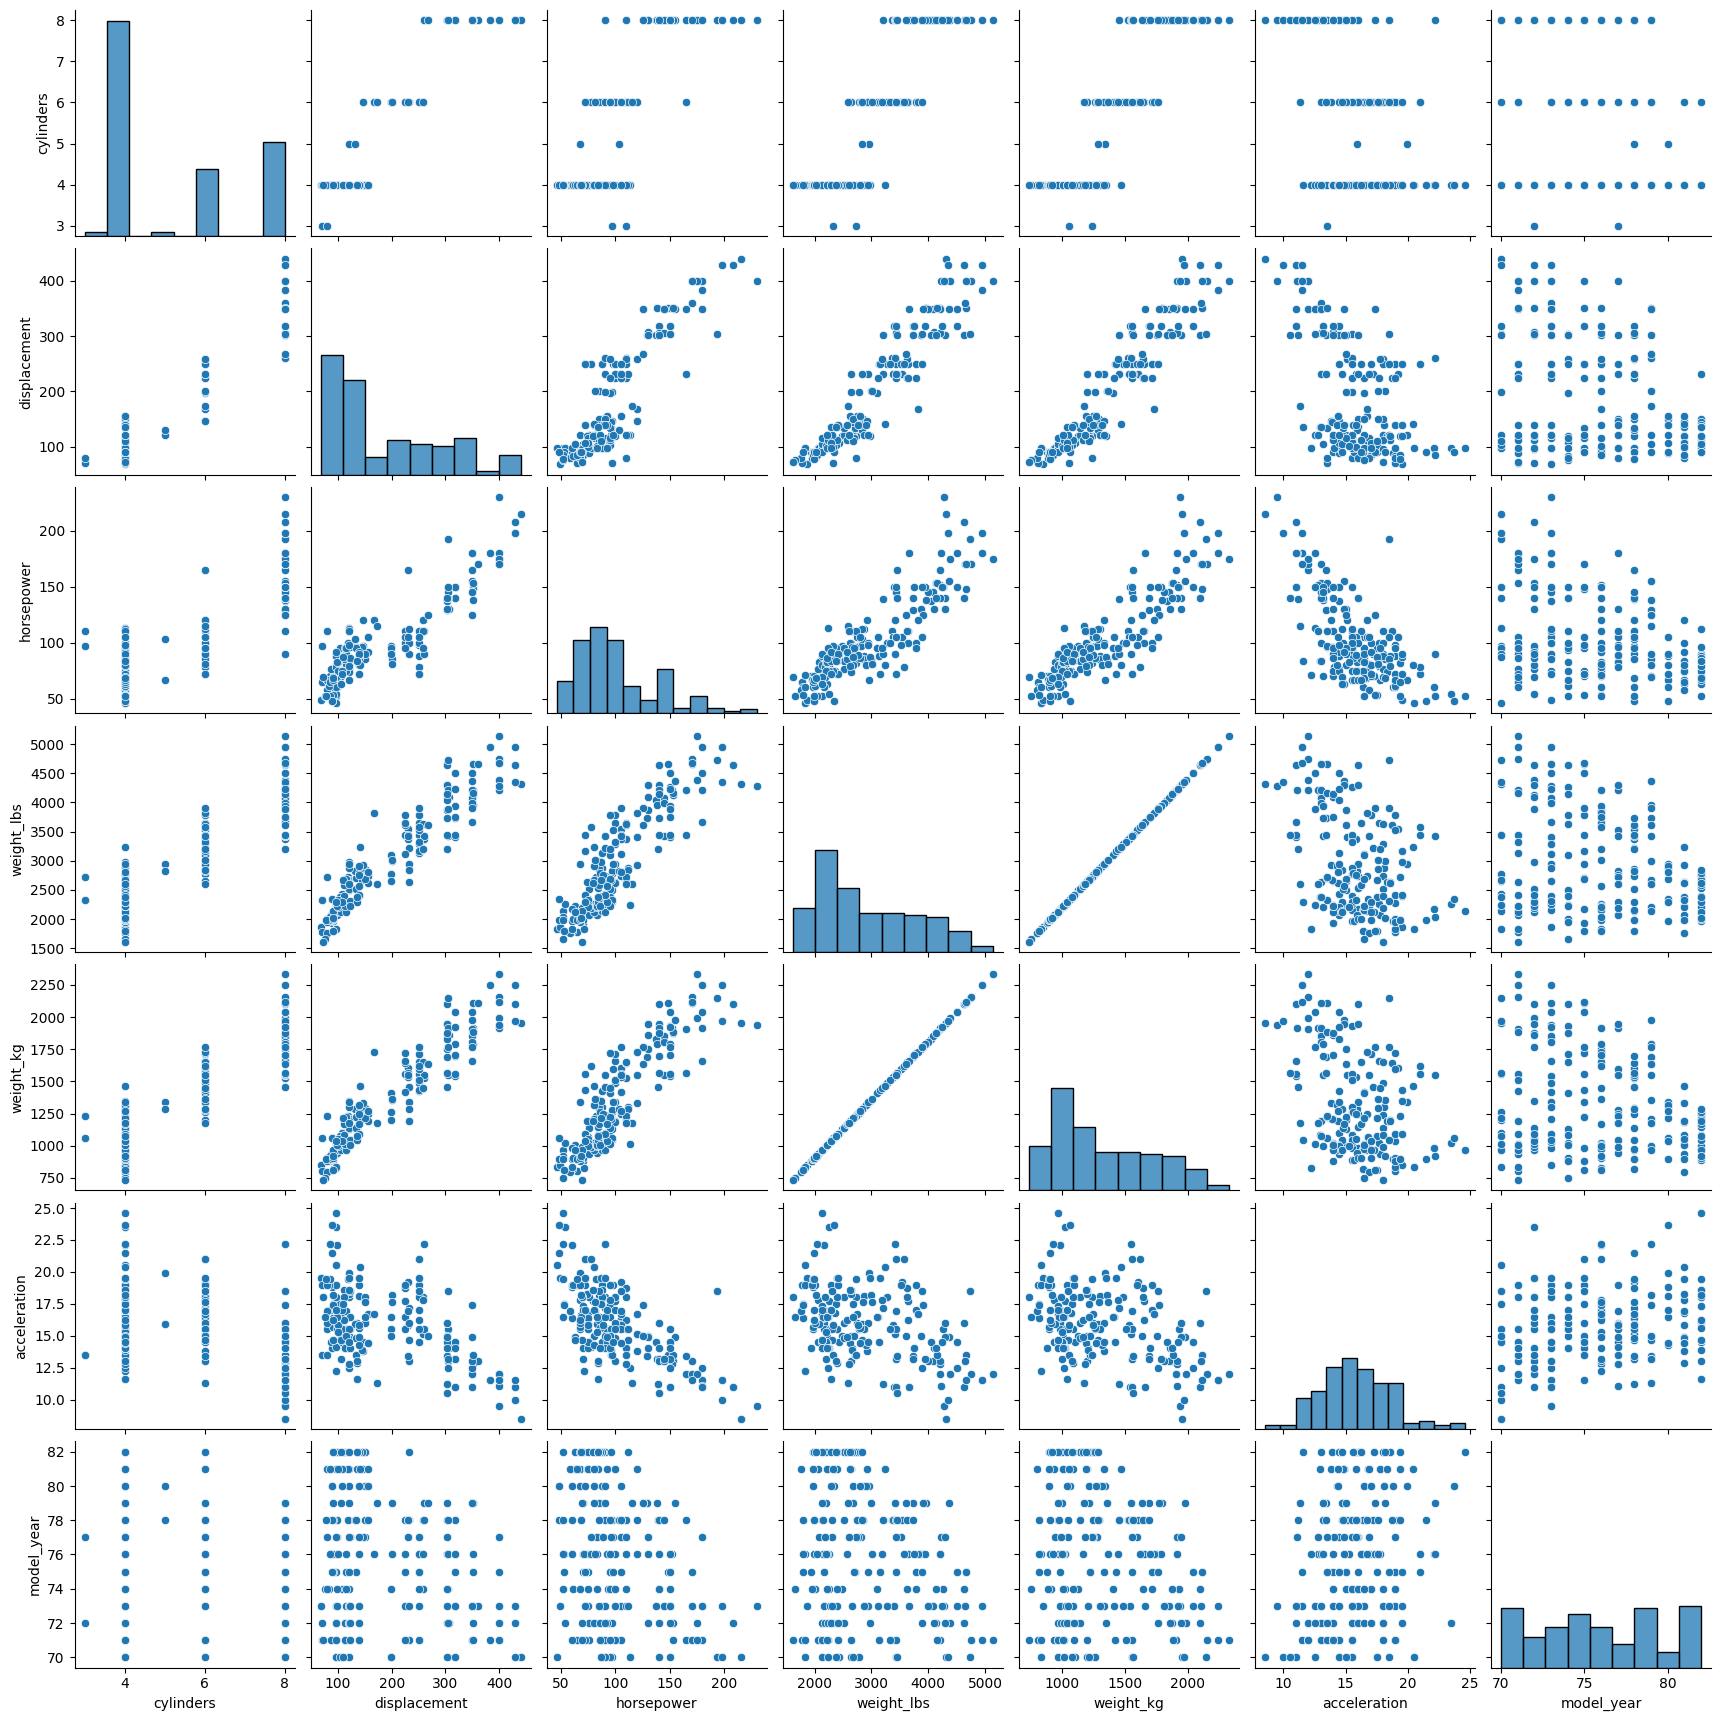

In [ ]:
sb.pairplot(data.iloc[:, 1:8])
plt.show()

Create Linear Regression model with all features and evaluate it using Cross-Validation.

In [ ]:
model = LinearRegression()

yHat = cross_val_predict(model, X, y, cv=10)

MSE = mean_squared_error(y, yHat)
R2 = r2_score(y, yHat)

print('MSE: %.3f' % MSE)
print('R^2: %.3f' % R2)

MSE: 2.170
R^2: 0.852


## **Feature selection with SFS**
And now this notebook's most important part – let's implement SFS and do feature selection with it.

In [ ]:
def SFS(X, y, model, feature_names):
  m = X.shape[1]

  current_bits = np.full(m, False)  # the current remembered solution

  overall_best_bits = np.full(m, False)  # the overall best found solution
  overall_best_mse = np.Inf  # evaluation of the best found solution

  # SFS iterations (as many iteration as there are features)
  for iter in range(1, m + 1):
    best_mse = np.Inf  # best evaluation in the current iteration
    best_j = -1  # best feature in the current iteration

    # going through all features
    for j in range(0, m):
      if current_bits[j]:  # if the feature is already included, we do nothing
        continue
      current_bits[j] = True  # inclusion of the feature

      X_selected = X[:, current_bits]  # data with the selected features
      yHat = cross_val_predict(model, X_selected, y, cv=10)
      MSE = mean_squared_error(y, yHat)
      # if better, remember it
      if MSE < best_mse:
        best_mse = MSE
        best_j = j

      current_bits[j] = False  # remove it to get back to original vector

    current_bits[best_j] = True  # inclusion of the best found feature

    # print best result in the current iteration
    print(f'Iteration {iter}: MSE = {best_mse}')
    print(''.join(['1' if bit else '0' for bit in current_bits]) + ': ' + '\t'.join(feature_names[current_bits]))
    print()

    # if better than the overall best, remember it
    if best_mse < overall_best_mse:
      overall_best_mse = best_mse
      overall_best_bits = current_bits.copy()

  # print the overall best result
  print('Overall best MSE =', overall_best_mse)
  print(''.join(['1' if bit else '0' for bit in overall_best_bits]) + ': ' + '\t'.join(feature_names[overall_best_bits]))

  # in addition, compute coefficient of determination
  X_selected = X[:, overall_best_bits]
  yHat = cross_val_predict(model, X_selected, y, cv=10)
  R2 = r2_score(y, yHat)
  print('Overall best R2 =', R2)

Run the function.

In [ ]:
SFS(X, y, model, feature_names)

Iteration 1: MSE = 3.314750626573363
00000100000000: weight_kg

Iteration 2: MSE = 2.009542299029658
00000101000000: weight_kg	model_year

Iteration 3: MSE = 1.99837669808344
00100101000000: displacement	weight_kg	model_year

Iteration 4: MSE = 1.9791029763643309
00100101000010: displacement	weight_kg	model_year	more_info_4

Iteration 5: MSE = 1.9854423422351437
00100111000010: displacement	weight_kg	acceleration	model_year	more_info_4

Iteration 6: MSE = 1.9928053685502451
00100111000011: displacement	weight_kg	acceleration	model_year	more_info_4	more_info_5

Iteration 7: MSE = 2.0086591997585863
00100111000111: displacement	weight_kg	acceleration	model_year	more_info_3	more_info_4	more_info_5

Iteration 8: MSE = 2.025780655613592
01100111000111: cylinders	displacement	weight_kg	acceleration	model_year	more_info_3	more_info_4	more_info_5

Iteration 9: MSE = 2.042497096829617
01100111010111: cylinders	displacement	weight_kg	acceleration	model_year	more_info_1	more_info_3	more_info_4	mo

## **There is a similar function in scikit-learn**

In [ ]:
# https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html
from sklearn.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', cv=10)
selector.fit(X, y)  # doing the search
selected = selector.get_support()  # getting the selected features
print(''.join(['1' if bit else '0' for bit in selected]) + ': ' + '\t'.join(feature_names[selector.get_support()]))

X_selected = X[:, selected]
yHat = cross_val_predict(model, X_selected, y, cv=10)
MSE = mean_squared_error(y, yHat)
R2 = r2_score(y, yHat)
print('Overall best MSE =', MSE)
print('Overall best R2 =', R2)

00100111010011: displacement	weight_kg	acceleration	model_year	more_info_1	more_info_4	more_info_5
Overall best MSE = 2.0120258331003713
Overall best R2 = 0.8625913177232697


---
*Notebook by Gints Jēkabsons*